In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import pandas as pd
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from scipy import stats
from PIL import Image
import pdb

/home/grads/a/akshatha.mohan/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/grads/a/akshatha.mohan/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# -----------------------------------------------------------------------------
# From https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension:
#
# In fractal geometry, the Minkowski–Bouligand dimension, also known as
# Minkowski dimension or box-counting dimension, is a way of determining the
# fractal dimension of a set S in a Euclidean space Rn, or more generally in a
# metric space (X, d).
# -----------------------------------------------------------------------------


# From https://github.com/rougier/numpy-100 (#87)
# From https://gist.github.com/rougier/e5eafc276a4e54f516ed5559df4242c0

import numpy as np


def boxcount(Z, k):
    """
    returns a count of squares of size kxk in which there are both colours (black and white), ie. the sum of numbers
    in those squares is not 0 or k^2
    Z: np.array, matrix to be checked, needs to be 2D
    k: int, size of a square
    """
    S = np.add.reduceat(
        np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)  # jumps by powers of 2 squares

    # We count non-empty (0) and non-full boxes (k*k)
    return len(np.where((S > 0) & (S < k * k))[0])


In [4]:


def boxcount_grayscale(Z, k):
    """
    find min and max intensity in the box and return their difference
    Z - np.array, array to find difference in intensities in
    k - int, size of a box
    """
    S_min = np.fmin.reduceat(
        np.fmin.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)
    S_max = np.fmax.reduceat(
        np.fmax.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)
    return S_max - S_min


In [5]:


def fractal_dimension(Z, threshold=0.9):
    """
    calculate fractal dimension of an object in an array defined to be above certain threshold as a count of squares
    with both black and white pixels for a sequence of square sizes. The dimension is the a coefficient to a poly fit
    to log(count) vs log(size) as defined in the sources.
    :param Z: np.array, must be 2D
    :param threshold: float, a thr to distinguish background from foreground and pick up the shape, originally from
    (0, 1) for a scaled arr but can be any number, generates boolean array
    :return: coefficients to the poly fit, fractal dimension of a shape in the given arr
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]



In [6]:

def fractal_dimension_grayscale(Z):
    """
    works the same as fractal_dimension() just does not look at counts and does not require a binary arr rather is looks
    at intensities (hence can be used for a grayscale image) and returns fractal dimensions D_B and D_M (based on sums
    and means), as described in https://imagej.nih.gov/ij/plugins/fraclac/FLHelp/Glossary.htm#grayscale
    :param Z: np. array, must be 2D
    :return: D_B and D_M fractal dimensions based on polyfit to log(sum) or log(mean) resp. vs log(sizes)
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    i_difference = []
    for size in sizes:
        i_difference.append(boxcount_grayscale(Z, size))

    # D_B
    d_b = [np.sum(x) for x in i_difference]

    # D_M
    d_m = [np.mean(x) for x in i_difference]

    # Fit the successive log(sizes) with log (sum)
    coeffs_db = np.polyfit(np.log(sizes), np.log(d_b), 1)
    # Fit the successive log(sizes) with log (mean)
    coeffs_dm = np.polyfit(np.log(sizes), np.log(d_m), 1)

    return -coeffs_db[0], -coeffs_dm[0]


In [7]:
def fractal_dimension_grayscale_DBC(Z):
    """
    Differential box counting method with implementation of appropriate box height selection.
    :param Z: 2D np.array
    :return: fd for a grayscale image
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # get the mean and standard deviation of the image intensity to rescale r
    mu = np.mean(Z)
    sigma = np.std(Z)

    # total number of gray levels, used for computing s'
    G = len(np.unique(Z))

    # scaled scale of each block, r=size(s)
    # TODO -- when to rescale, what should a be
    # when to rescale -- either always or when the pixels in the selected box don't fall in +- 1 std, so far always
    a = 1
    r_prime = sizes / (1 + 2 * a * sigma)

    # Actual box counting with decreasing size
    i_difference = []
    for size in sizes:
        # rescale
        n_r = np.ceil(boxcount_grayscale(Z, size) / r_prime)
        # if max==min per the box, replace the 0 result with 1
        n_r[n_r == 0] = 1
        i_difference.append(n_r)

    # contribution from all boxes
    N_r = [np.sum(x) for x in i_difference]

    # Fit the successive log(sizes) with log (sum)
    coeffs = np.polyfit(np.log(sizes), np.log(N_r), 1)

    return -coeffs[0]


In [8]:
def fractal_dimension_grayscale_DBC(Z):
    """
    Differential box counting method with implementation of appropriate box height selection.
    :param Z: 2D np.array
    :return: fd for a grayscale image
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n_exp = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n_exp = int(np.log(n_exp) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n_exp, 1, -1)

    # get the mean and standard deviation of the image intensity to rescale r
    mu = np.mean(Z)
    sigma = np.std(Z)

    # total number of gray levels, used for computing s'
    G = len(np.unique(Z))

    # scaled scale of each block, r=size(s)
    # TODO -- when to rescale, what should a be
    # when to rescale -- either always or when the pixels in the selected box don't fall in +- 1 std, so far always
    a = 1
    r_prime = sizes / (1 + 2 * a * sigma)

    # Actual box counting with decreasing size
    i_difference = []
    
    #Add counter to increment through r_prime
    r_count = 0
    for size in sizes:
        # rescale
        n_r = np.ceil(boxcount_grayscale(Z, size) / r_prime[r_count])
        # if max==min per the box, replace the 0 result with 1
        n_r[n_r == 0] = 1
        i_difference.append(n_r)
        r_count += 1

    # contribution from all boxes
    N_r = [np.sum(x) for x in i_difference]

    # Fit the successive log(sizes) with log (sum)
    coeffs = np.polyfit(np.log(sizes), np.log(N_r), 1)

    return -coeffs[0]


def lacunarity_global(Z, eps = 10e-6):
    '''
    Lacunarity definition from Fast Unsupervised Seafloor Characterization
    in Sonar Imagery Using Lacunarity
    '''
    mean = np.mean(Z)
    std = np.std(Z)
    
    #Lacunarity is the ratio between variance and squared mean
    L = std / ((mean ** 2) + eps)
    
    #Revisist Pytorch implementation
    # #Convert input to tensor
    # Z_tensor = torch.tensor(Z).unsqueeze(0).unsqueeze(0).float()
    
    # #Define sum pooling 
    # sum_pool = nn.AdaptiveAvgPool2d(1)
    
    # #Compute numerator (n * sum of squared pixels) and denominator (squared sum of pixels) 
    # n_pts = np.prod(np.asarray(Z.shape))
    # L_numerator = (n_pts) * sum_pool(n_pts * Z_tensor.square())
    # L_denominator = sum_pool(n_pts * Z_tensor).square()

    # #Lacunarity is L_numerator / L_denominator - 1
    # L_torch = (L_numerator / L_denominator) - 1
    
    # #Convert back to numpy array
    # L_torch = L.squeeze(0).squeeze(0)
    # L_torch = L.detach().cpu().numpy()
    # pdb.set_trace()
    return L
    
def lacunarity_local(Z,kernel_size=[3,3],stride=1,dilation=1):
    '''
    Lacunarity definition from Fast Unsupervised Seafloor Characterization
    in Sonar Imagery Using Lacunarity
    Integral image used
    Leveraging pytorch (may implement as convolution layer later for more flexibility)
    '''
    
    #Convert input to tensor
    Z_tensor = torch.tensor(Z).unsqueeze(0).unsqueeze(0).float()
    
    #Define sum pooling 
    sum_pool = nn.Conv2d(1, 1, kernel_size,stride=stride,dilation=dilation,
                         padding='same',padding_mode='reflect',bias=False)
    
    sum_pool.weight.data = torch.ones(sum_pool.weight.shape) 
    sum_pool.weight.requires_grad = False
    # sum_pool = nn.AvgPool2d(kernel_size,stride=stride,count_include_pad=False,divisor_override=1,
                            # padding=kernel_size[0]//2)
    
    #Compute numerator (n * sum of squared pixels) and denominator (squared sum of pixels) 
    n_pts = np.prod(np.asarray(kernel_size))
    L_numerator = n_pts * sum_pool(Z_tensor.square())
    L_denominator = sum_pool(Z_tensor).square()

    #Lacunarity is L_numerator / L_denominator - 1
    L = (L_numerator / L_denominator) - 1
    
    #Convert back to numpy array
    L = L.squeeze(0).squeeze(0)
    L = L.detach().cpu().numpy()
    
    return L
    
    

In [9]:
data_flag = 'bloodmnist'
download = True

BATCH_SIZE = 128


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [10]:
# preprocessing
data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/grads/a/akshatha.mohan/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/grads/a/akshatha.mohan/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/grads/a/akshatha.mohan/.medmnist/bloodmnist.npz


In [11]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([128, 3, 28, 28])

In [12]:
image_array = images[120].numpy()
image_array.shape
X = images[120]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


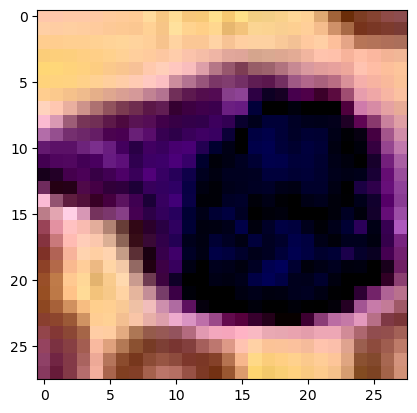

In [13]:
plt.imshow(np.transpose((images[120]).to('cpu').numpy(), (1, 2, 0)))
plt.show()

In [34]:
class Global_Lacunarity(nn.Module):
    def __init__(self, dim=2, eps = 10E-6, kernel = None, stride = None, padding = None):


        # inherit nn.module
        super(Global_Lacunarity, self).__init__()

        # define layer properties
        self.dim = dim
        self.eps = eps
        self.kernel = kernel
        self.stride = stride
        self.padding = padding

        #For each data type, apply two 1x1 convolutions, 1) to learn bin center (bias)
        # and 2) to learn bin width
        # Time series/ signal Data
        if self.kernel is None:
            if self.dim == 1:
                self.gap_layer = nn.AdaptiveAvgPool1d(1)
            
            # Image Data
            elif self.dim == 2:
                self.gap_layer = nn.AdaptiveAvgPool2d(1)
            
            # Spatial/Temporal or Volumetric Data
            elif self.dim == 3:
                self.gap_layer = nn.AdaptiveAvgPool3d(1)
             
            else:
                raise RuntimeError('Invalid dimension for global lacunarity layer')
        else:
            if self.dim == 1:
                self.gap_layer = nn.AvgPool1d((kernel[0]), stride=stride[0], padding=(0))
            
            # Image Data
            elif self.dim == 2:
                self.gap_layer = nn.AvgPool2d((kernel[0], kernel[1]), stride=(stride[0], stride[1]), padding=(0, 0))
            
            # Spatial/Temporal or Volumetric Data
            elif self.dim == 3:
                self.gap_layer = nn.AvgPool3d((kernel[0], kernel[1], kernel[2]), stride=(stride[0], stride[1], stride[2]), padding=(0, 0, 0))
             
            else:
                raise RuntimeError('Invalid dimension for global lacunarity layer')

        
    def forward(self,x):
        #Compute squared tensor
        #pdb.set_trace()
        squared_x_tensor = x ** 2

        #Get number of samples 
        n_pts = np.prod(np.asarray(x.shape[-2:]))

        #Compute numerator (n * sum of squared pixels) and denominator (squared sum of pixels)
        L_numerator = ((n_pts)**2) * (self.gap_layer(squared_x_tensor))
        L_denominator = (n_pts * self.gap_layer(x))**2

        #Check global lacunarity value for equivalence
        #global_lac_val = torch.var(x,dim=(-1,-2))/((torch.mean(x,dim=(-1,-2)))**2)

        #Lacunarity is L_numerator / L_denominator - 1
        x = (L_numerator / (L_denominator + self.eps)) - 1


        #pdb.set_trace()
        return x
  


In [15]:
images[120].shape

torch.Size([3, 28, 28])

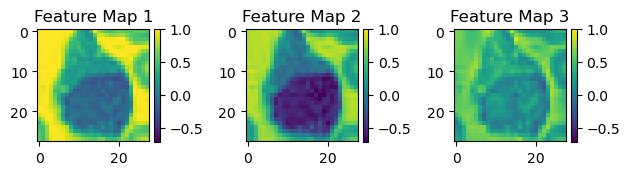

In [16]:
conv = images[120].shape[0]
min_value = images[120].min().item()
max_value = images[120].max().item()
# Plot each feature map
fig, ax = plt.subplots(1,conv)
for channel in range(0, conv):
    im = ax[channel].imshow(images[120].permute(2,1,0).detach().numpy()[:,:,channel], vmin = min_value, vmax = max_value)
    plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[channel])
    ax[channel].set_title('Feature Map {}'.format(channel+1))
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


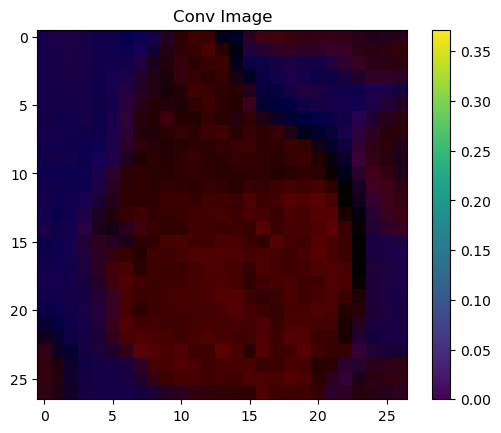

In [17]:

conv = nn.Conv2d(3, out_channels=3, kernel_size=2, stride=1)
conv_output = conv(X)
# Plot the image
plt.imshow(conv_output.permute(2,1,0).detach().numpy())
plt.colorbar()
plt.title('Conv Image')
plt.show()

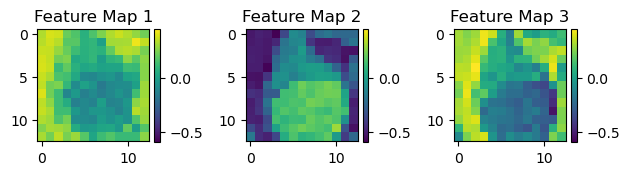

In [18]:

conv = nn.Conv2d(3, out_channels=3, kernel_size=3, stride=2)
conv_output = conv(X)
min_value = conv_output.min().item()
max_value = conv_output.max().item()
# Plot each feature map
fig, ax = plt.subplots(1,conv.out_channels)
for channel in range(0, conv.out_channels):
    im = ax[channel].imshow(conv_output.permute(2,1,0).detach().numpy()[:,:,channel], vmin = min_value, vmax = max_value)
    plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[channel])
    ax[channel].set_title('Feature Map {}'.format(channel+1))
plt.tight_layout()
plt.show()

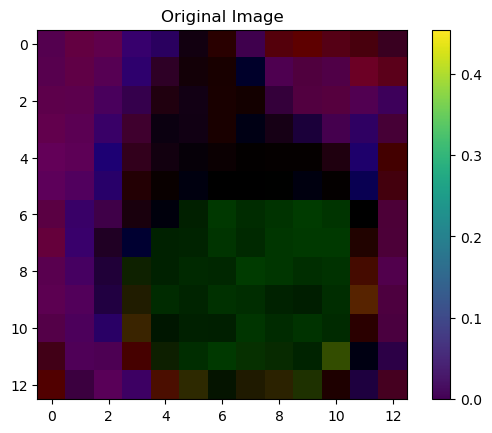

In [19]:
relu = nn.ReLU()
relu_output = relu(conv_output)
# Plot the image
plt.imshow(relu_output.permute(2,1,0).detach().numpy())
plt.colorbar()
plt.title('Original Image')
plt.show()

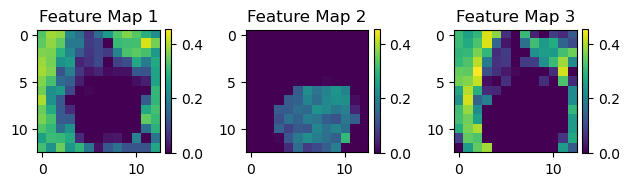

In [20]:
relu = nn.ReLU()
relu_output = relu(conv_output)
min_value = relu_output.min().item()
max_value = relu_output.max().item()
# Plot each feature map
fig, ax = plt.subplots(1,conv.out_channels)
for channel in range(0, conv.out_channels):
    im = ax[channel].imshow(relu_output.permute(2,1,0).detach().numpy()[:,:,channel], vmin = min_value, vmax = max_value)
    plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[channel])
    ax[channel].set_title('Feature Map {}'.format(channel+1))
plt.tight_layout()
plt.show()

/tmp/ipykernel_3196802/4044465802.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(lac_pooling_output).permute(2,1,0).detach().numpy())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


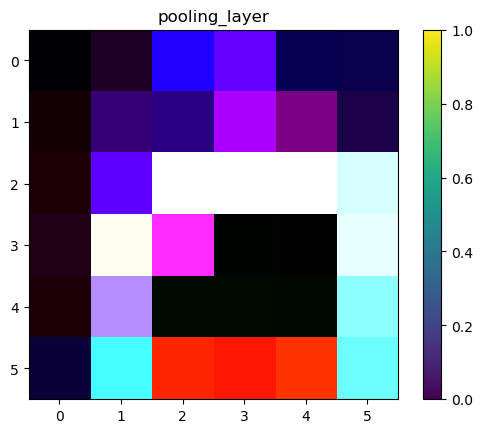

In [36]:
lac_pooling_layer = Global_Lacunarity(kernel=(3,3), stride=(2,2), padding=(0,0))
lac_pooling_output = lac_pooling_layer(relu_output)

# Plot the image
plt.imshow(torch.tensor(lac_pooling_output).permute(2,1,0).detach().numpy())
plt.colorbar()
plt.title('pooling_layer')
plt.show()

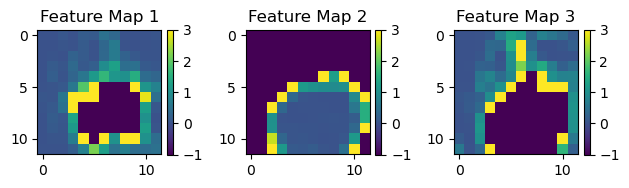

In [37]:
lac_pooling_layer = Global_Lacunarity(kernel=(2,2), stride=(1,1), padding=(0,0))
lac_pooling_output = lac_pooling_layer(relu_output)
min_value = lac_pooling_output.min().item()
max_value = lac_pooling_output.max().item()
# Plot each feature map
fig, ax = plt.subplots(1,conv.out_channels)
for channel in range(0, conv.out_channels):
    im = ax[channel].imshow(lac_pooling_output.permute(2,1,0).detach().numpy()[:,:,channel], vmin = min_value, vmax = max_value)
    plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[channel])
    ax[channel].set_title('Feature Map {}'.format(channel+1))
plt.tight_layout()
plt.show()

In [23]:
lac_pooling_output

tensor([[[0.7772]],

        [[2.5079]],

        [[1.2437]]], grad_fn=<SubBackward0>)

In [33]:
global_val

tensor([0.7818, 2.5228, 1.2511], grad_fn=<DivBackward0>)

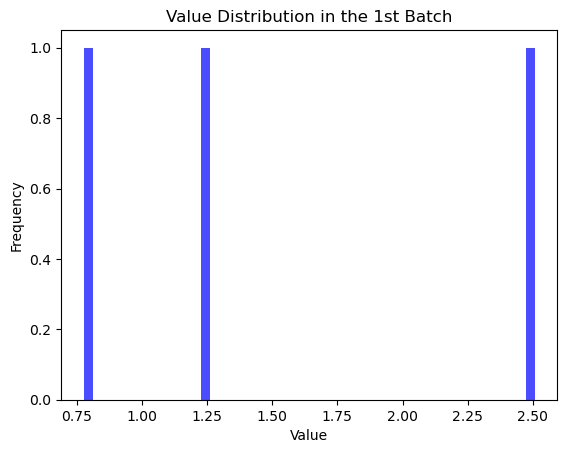

In [24]:
lac_flat_data = lac_pooling_output.view(-1).detach().numpy()

# Plot the histogram
plt.hist(lac_flat_data, bins=50, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Value Distribution in the 1st Batch')
plt.show()

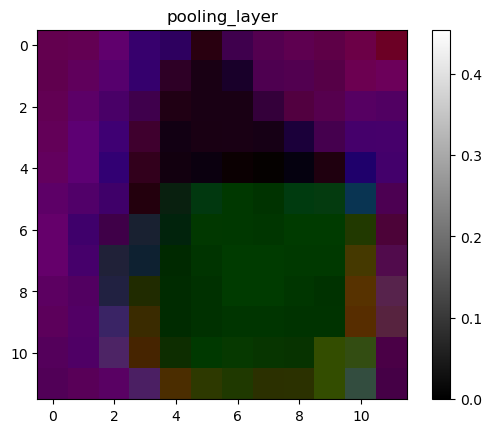

In [25]:
max_pooling_layer = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(0, 0))
max_pooling_output = max_pooling_layer(relu_output)
# Plot the image
plt.imshow(max_pooling_output.permute(2,1,0).detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('pooling_layer')
plt.show()

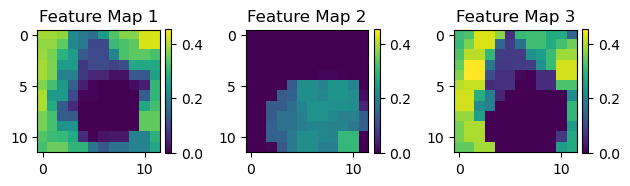

In [26]:
max_pooling_layer = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(0, 0))
max_pooling_output = max_pooling_layer(relu_output)
min_value = max_pooling_output.min().item()
max_value = max_pooling_output.max().item()
# Plot each feature map
fig, ax = plt.subplots(1,conv.out_channels)
for channel in range(0, conv.out_channels):
    im = ax[channel].imshow(max_pooling_output.permute(2,1,0).detach().numpy()[:,:,channel], vmin = min_value, vmax = max_value)
    plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[channel])
    ax[channel].set_title('Feature Map {}'.format(channel+1))
plt.tight_layout()
plt.show()

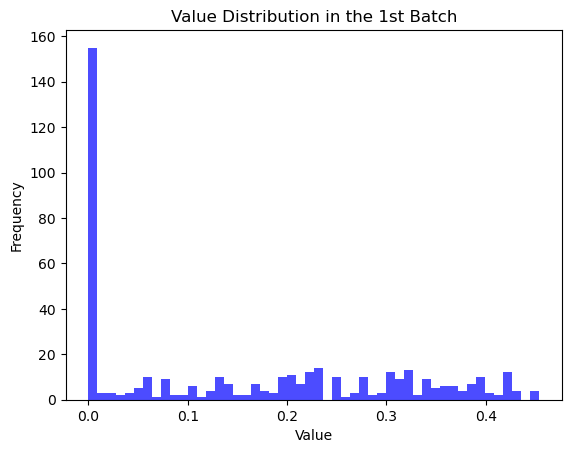

In [27]:
max_flat_data = max_pooling_output.view(-1).detach().numpy()

# Plot the histogram
plt.hist(max_flat_data, bins=50, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Value Distribution in the 1st Batch')
plt.show()

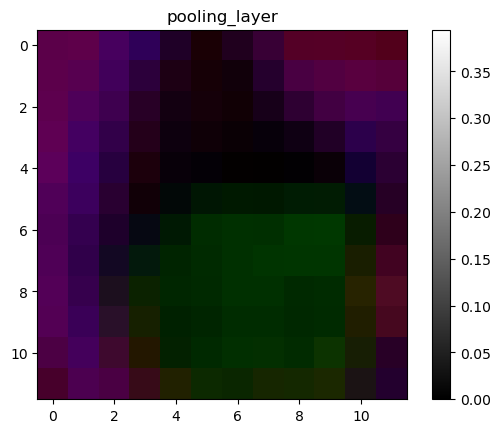

In [28]:
avg_pooling_layer = nn.AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
avg_pooling_output = avg_pooling_layer(relu_output)
# Plot the image
plt.imshow(avg_pooling_output.permute(2,1,0).detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('pooling_layer')
plt.show()

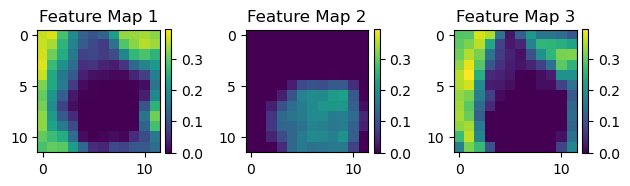

In [29]:
avg_pooling_layer = nn.AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
avg_pooling_output = avg_pooling_layer(relu_output)
min_value = avg_pooling_output.min().item()
max_value = avg_pooling_output.max().item()
# Plot each feature map
fig, ax = plt.subplots(1,conv.out_channels)
for channel in range(0, conv.out_channels):
    im = ax[channel].imshow(avg_pooling_output.permute(2,1,0).detach().numpy()[:,:,channel], vmin = min_value, vmax = max_value)
    plt.colorbar(im,fraction=0.046, pad=0.04,ax=ax[channel])
    ax[channel].set_title('Feature Map {}'.format(channel+1))
plt.tight_layout()
plt.show()

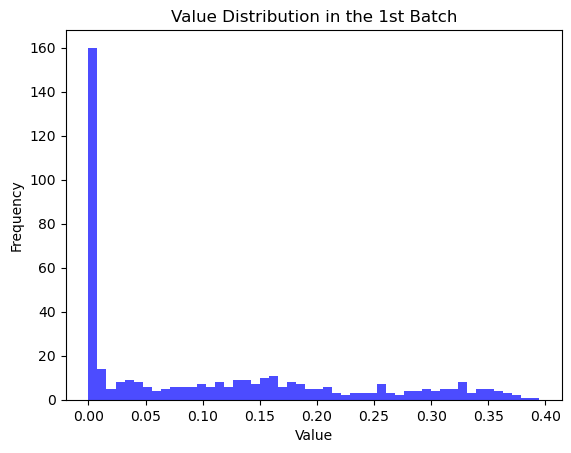

In [30]:
avg_flat_data = avg_pooling_output.view(-1).detach().numpy()

# Plot the histogram
plt.hist(avg_flat_data, bins=50, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Value Distribution in the 1st Batch')
plt.show()

In [31]:
#load image, if you use grayscale iamge, cosine similarity will be 1 (input dim = 1)
X = images[120]


#Compute similarity feature (currenlty have 'norm' or 'cosine')
channels = X.shape[1]
Lancunarity_Layer = Global_Lacunarity(kernel=(3,3), stride=(2,2), padding=(0,0))
similarity_features = Lancunarity_Layer(X)

In [32]:
import matplotlib.pyplot as plt
import torch

# Assuming similarity_features has shape [1, 28, 1, 13]
similarity_features_reshaped = similarity_features.squeeze().detach().numpy()

# Plot the image
plt.imshow(X.squeeze().permute(2,1,0).numpy())
plt.title('Original Image')
plt.show()

# Plot the lacunarity values as a heatmap
plt.imshow(similarity_features.squeeze().permute(2,1,0).numpy(), aspect='auto')
plt.title('Lacunarity Heatmap')
plt.colorbar()
plt.show()


AttributeError: 'tuple' object has no attribute 'squeeze'

In [ ]:
gray_image = Image.fromarray((image_array.mean(axis=0) * 255).astype('uint8'), 'L')
gray_image = np.array(gray_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


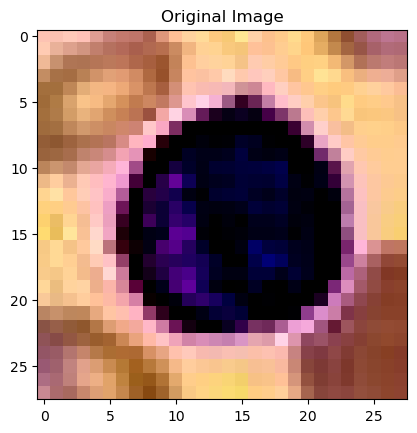

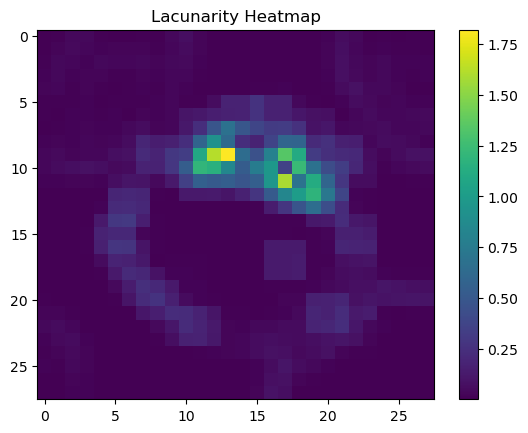

In [ ]:
temp = lacunarity_local(gray_image)
temp.shape

# Plot the image
plt.imshow(images[120].permute(2,1,0).detach().numpy())
plt.title('Original Image')
plt.show()

# Plot the lacunarity values as a heatmap
plt.imshow(temp, aspect='auto')
plt.title('Lacunarity Heatmap')
plt.colorbar()
plt.show()

DBC

In [ ]:
def fractal_dimension_grayscale_DBC_get_box_sizes(Z):
    """
    Differential box counting method with implementation of appropriate box height selection.
    :param Z: 3D torch.Tensor (channels, height, width)
    :return: box_sizes, r_prime for a grayscale image
    """

    # Minimal dimension of image
    p = torch.tensor(Z.size(2))

    # Greatest power of 2 less than or equal to p
    n_exp = 2 ** torch.floor(torch.log2(p))

    # Extract the exponent
    n_exp = int(torch.log2(n_exp))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** torch.arange(n_exp, 1, -1)

    # get the mean and standard deviation of the image intensity to rescale r
    mu = torch.mean(Z[0])
    sigma = torch.std(Z[0])

    # when to rescale -- either always or when the pixels in the selected box don't fall in +- 1 std, so far always
    a = 1
    r_prime = sizes / (1 + 2 * a * sigma)

    return sizes, r_prime

In [ ]:
import torch

def differential_height(u, v):
    return v - u - 1

def probability_function(image, mass, r):
    count = torch.sum(image == mass)
    total_boxes = image.numel()
    return count / total_boxes

def differential_box_counting_lacunarity(image, window_size, box_size):
    """
    Calculate lacunarity using Differential Box-Counting (DBC) method for a grayscale image.

    Args:
    - image (torch.Tensor): Grayscale image tensor (2D).
    - window_size (int): Size of the overlapping windows.
    - box_size (int): Size of the boxes.

    Returns:
    - lacunarity_map (torch.Tensor): Lacunarity map for the image.
    """
    # Ensure input is a tensor
    image = torch.tensor(image, dtype=torch.float32)

    # Calculate the number of cubes needed to cover the box
    cubes_needed = window_size // box_size

    # Initialize lacunarity map
    lacunarity_map = torch.zeros_like(image)
    # Initialize list to store all differential heights
    all_heights = []

    # Iterate over overlapping windows
    for i in range(0, image.shape[0] - window_size + 1, 1):
        for j in range(0, image.shape[1] - window_size + 1, 1):
            # Extract the current window
            window = image[i:i+window_size, j:j+window_size]

            # Initialize mass for the window
            window_mass = torch.zeros_like(window)

            # Initialize list to store the differential heights for each box
            heights = []

            # Iterate over boxes within the window
            for box_i in range(cubes_needed):
                for box_j in range(cubes_needed):
                    # Extract the current box
                    box = window[box_i*box_size:(box_i+1)*box_size, box_j*box_size:(box_j+1)*box_size]

                    # Calculate the differential height of the column
                    max_value = torch.max(box)
                    min_value = torch.min(box)

                    u = torch.ceil(min_value / box_size)
                    v = torch.ceil(max_value / box_size)

                    differential_height = torch.absolute(u - v - 1)
                    # Append the differential height to the list
                    heights.append(differential_height.item())

            # Update the list of all differential heights
            all_heights.extend(heights)

    # Calculate N(r)
    N_r = len(all_heights)

    # Calculate q-values for all differential heights
    q_values = [1 / N_r] * len(all_heights)

    print(f"N(r) = {all_heights}")
    print(f"q-values: {q_values}")

    # Calculate lacunarity value for the current window
    numerator = sum([mass**2 * q_value for mass, q_value in zip(all_heights, q_values)])
    print(numerator)
    denominator = sum([mass * q_value for mass, q_value in zip(all_heights, q_values)])


    # Avoid division by zero
    lacunarity_value = numerator / denominator**2 if denominator != 0 else 0.0


    # Update lacunarity map for the current window
    print(lacunarity_value)
    lacunarity_map[i:i+window_size, j:j+window_size] = lacunarity_value

    return lacunarity_map

# Example usage:
image = torch.tensor([[9, 10, 11, 19], [18, 18, 17, 3], [7, 10, 18, 16], [18, 17, 13, 22]], dtype=torch.float32)

window_size = 3
box_size = 3

lacunarity_map = differential_box_counting_lacunarity(image, window_size, box_size)
print(lacunarity_map)



N(r) = [4.0, 7.0, 4.0, 8.0]
q-values: [0.25, 0.25, 0.25, 0.25]
36.25
1.0964083175803403
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0964, 1.0964, 1.0964],
        [0.0000, 1.0964, 1.0964, 1.0964],
        [0.0000, 1.0964, 1.0964, 1.0964]])


/tmp/ipykernel_2879208/3165182111.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


In [ ]:
import torch

def differential_box_counting_lacunarity_iterative(image, window_size, box_size):
  """
  Calculate lacunarity using Differential Box-Counting (DBC) method for a grayscale image without recursion.

  Args:
    image (torch.Tensor): Grayscale image tensor (2D).
    window_size (int): Size of the overlapping windows.
    box_size (int): Size of the boxes.

  Returns:
    lacunarity_value (float): Lacunarity value for the image.
  """

  # Ensure input is a tensor
  image = torch.tensor(image, dtype=torch.float32)

  # Calculate the number of cubes needed to cover the box
  cubes_needed = window_size // box_size

  # Initialize lacunarity value
  lacunarity_value = 0.0

  # Iterate over overlapping windows
  for i in range(0, image.shape[0] - window_size + 1, 1):
    for j in range(0, image.shape[1] - window_size + 1, 1):
      # Extract the current window
      window = image[i:i+window_size, j:j+window_size]

      # Calculate the differential height for each box
      differential_heights = []
      for box_i in range(cubes_needed):
        for box_j in range(cubes_needed):
          # Extract the current box
          box = window[box_i*box_size:(box_i+1)*box_size, box_j*box_size:(box_j+1)*box_size]

          # Calculate the differential height of the box
          max_value = torch.max(box)
          min_value = torch.min(box)

          u = torch.ceil(min_value / box_size)
          v = torch.ceil(max_value / box_size)

          differential_height = torch.absolute(u - v - 1)

          # Append the differential height to the list
          differential_heights.append(differential_height.item())

      # Update the lacunarity value
      lacunarity_value += sum(differential_heights)

  # Calculate the average differential height
  lacunarity_value /= image.numel()

  return lacunarity_value


def calculate_lacunarity_feature_maps(image, window_sizes):
  """
  Calculate lacunarity feature maps for individual windows in an image.

  Args:
    image (torch.Tensor): Grayscale image tensor (2D).
    window_sizes (list[int]): List of window sizes.

  Returns:
    lacunarity_feature_maps (list[torch.Tensor]): List of lacunarity feature maps, one for each window size.
  """

  lacunarity_feature_maps = []
  for window_size in window_sizes:
    # Use the iterative version of the differential_box_counting_lacunarity() function
    lacunarity_map = differential_box_counting_lacunarity_iterative(image, window_size, window_size)
    lacunarity_feature_maps.append(lacunarity_map)

  return lacunarity_feature_maps


# Example usage:
image = torch.tensor([[9, 10, 11, 19], [18, 18, 17, 3], [7, 10, 18, 16], [18, 17, 13, 22]], dtype=torch.float32)

window_sizes = [3, 5, 7]

lacunarity_feature_maps = calculate_lacunarity_feature_maps(image, window_sizes)

# Print the lacunarity feature maps
for i in range(len(lacunarity_feature_maps)):
  print(f"Lacunarity feature map for window size {window_sizes[i]}:")
  print(lacunarity_feature_maps[i])

Lacunarity feature map for window size 3:
1.4375
Lacunarity feature map for window size 5:
0.0
Lacunarity feature map for window size 7:
0.0


/tmp/ipykernel_2879208/2577985950.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
